In [ ]:
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Code for some unsupervised algorithms
# Right now for individual event 1 files
# Runs k-means clustering and 
# Dayla's cool RF unsupervised algorithm, which is trained to decipher
# between frankenstein data [reproduces distribution of parameters
# but without correlations] and real data and then identifies outliers.
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [66]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma

def plot_from_df(df, name, var1, var2):
    df = df.dropna()
 
    x = df[var1]#[0:n_points]#[np.array(binary_preds)==1]#model_lda.predict(xs)
    y = df[var2]#[0:n_points]#[np.array(binary_preds)==1]

    
    
    nbins=100#int(len(x)/10)
    
    img_data, yedges, xedges = np.histogram2d(y, x, nbins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    try:
        plt.clf()
        plt.imshow(ma.masked_where(img_data==0, img_data),  
                        rasterized=True, cmap='viridis', origin='data', extent=extent, 
                       norm=matplotlib.colors.LogNorm())
        plt.xlabel(var1)
        plt.ylabel(var2)
    
        plt.colorbar()
        plt.title(name)
        plt.show()
    except:
        plt.clf()
        plt.imshow(ma.masked_where(img_data==0, img_data),  
                        rasterized=True, cmap='viridis', origin='data', extent=extent)
        plt.xlabel(var1)
        plt.ylabel(var2)
        plt.colorbar()
        plt.title(name)
        plt.show()
    
    
    '''plt.clf()
    plt.scatter(x, y, c = df['pha'], cmap='viridis')
    plt.colorbar()
    plt.title(name)
    plt.show()'''

In [7]:
# Import .csv files from event file
datadir = '../data/csv_files/'
id = 1505

# These 'science_dataframe' files are event 1 files with the gti mask applied (but no additional filtering)
data = pd.io.parsers.read_csv(datadir+'science_dataframe_'+str(id)+'.csv', sep=',')#, header=[0])
print(data)
plot_from_df(data, 'Cas A', 'x', 'y')

         Unnamed: 0          time  crsv  crsu  amp_sf  av1   av2  av3  au1  \
0                 0  6.196317e+07    31    33       1  102   501   46   42   
1                 1  6.196317e+07    22    27       1   50   433   81   42   
2                 2  6.196318e+07    47    13       1  204   612   57  288   
3                 3  6.196318e+07    40    33       1  193   852   75  422   
4                 4  6.196318e+07     2    21       1  394   542   22   55   
...             ...           ...   ...   ...     ...  ...   ...  ...  ...   
6951805     6951805  6.201342e+07    29    31       1  314  1147   70  192   
6951806     6951806  6.201342e+07    16    57       1  192   409   28   90   
6951807     6951807  6.201342e+07    28    30       1  264  1744  148  492   
6951808     6951808  6.201342e+07    57    56       1  325   487  217   89   
6951809     6951809  6.201342e+07    32    20       1  290   416   29  265   

          au2  ...  PI exceeding 255  Event time tag is out of 

NameError: name 'ma' is not defined

<Figure size 432x288 with 0 Axes>

In [8]:
print(data.columns)

Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of seque

In [9]:
# Prepare the fp and fb variables:
a_u = data["au1"]  # otherwise known as "a1"
b_u = data["au2"]  # "a2"
c_u = data["au3"]  # "a3"

a_v = data["av1"]
b_v = data["av2"]
c_v = data["av3"]

with np.errstate(invalid='ignore'):
    # Do the U axis
    fp_u = ((c_u - a_u) / (a_u + b_u + c_u))
    fb_u = b_u / (a_u + b_u + c_u)

    # Do the V axis
    fp_v = ((c_v - a_v) / (a_v + b_v + c_v))
    fb_v = b_v / (a_v + b_v + c_v)

data['fp_u'] = fp_u
data['fb_u'] = fb_u
data['fp_v'] = fp_v
data['fb_v'] = fb_v

In [114]:
# Select which predictors you want to include in the clustering:
print('options for features', data.columns[:])

all_feature_list = ['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event time tag is out of sequence', 'V amp flatness test failed',
       'U amp flatness test failed', 'V amp saturation test failed',
       'U amp saturation test failed', 'V hyperbolic test failed',
       'U hyperbolic test failed', 'Hyperbola test passed',
       'Hyperbola test failed']

feature_list = ['time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v']

feature_list = [ 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'pha', 'pi', 'sumamps']


data_select = data[feature_list]

# Also delete nans
data_select = data_select.dropna()

options for features Index(['Unnamed: 0', 'time', 'crsv', 'crsu', 'amp_sf', 'av1', 'av2', 'av3',
       'au1', 'au2', 'au3', 'rawx', 'rawy', 'chipx', 'chipy', 'tdetx', 'tdety',
       'detx', 'dety', 'x', 'y', 'pha', 'pi', 'sumamps', 'chip_id', 'fp_u',
       'fb_u', 'fp_v', 'fb_v', 'AV3 corrected for ringing',
       'AU3 corrected for ringing', 'Event impacted by prior event (piled up)',
       'Shifted event time', 'Event telemetered in NIL mode',
       'V axis not triggered', 'U axis not triggered',
       'V axis center blank event', 'U axis center blank event',
       'V axis width exceeded', 'U axis width exceeded', 'Shield PMT active',
       'Upper level discriminator not exceeded',
       'Lower level discriminator not exceeded', 'Event in bad region',
       'Amp total on V or U = 0', 'Incorrect V center', 'Incorrect U center',
       'PHA ratio test failed', 'Sum of 6 taps = 0', 'Grid ratio test failed',
       'ADC sum on V or U = 0', 'PI exceeding 255',
       'Event tim

In [115]:
# Standardize the data prior to k-means:
standardized_data = preprocessing.scale(data_select)
print(standardized_data)

[[-2.30472112 -0.80283984 -2.46017049 ... -2.17803629 -2.38029617
  -2.41368352]
 [-2.30472112 -0.88126996 -2.54847827 ... -2.17803629 -2.36459301
  -2.46515259]
 [-2.30472112 -0.64899613 -2.31602101 ... -2.14867398 -2.2703741
  -2.18916492]
 ...
 [-2.30472112 -0.55849983 -0.84595612 ... -1.88441318 -2.09763943
  -1.2124685 ]
 [-2.30472112 -0.46649526 -2.4783515  ... -2.10463052 -2.09763943
  -2.02178915]
 [-2.30472112 -0.51928477 -2.57055522 ... -2.13399283 -2.31748356
  -2.33303514]]


In [116]:

print(np.shape(standardized_data))

(6951810, 10)


In [117]:
### Okay, why not run q quick clustering ?

nclusters=2
kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(standardized_data)
centers = kmeans.cluster_centers_#.reshape(nclusters, resampling_shape, resampling_shape)
print('centers', centers)
# These are meant to be repopulated every time you cut the galaxies
#bad_galaxies = np.zeros(np.shape(MB_matrix_rescaled))
#bad_galaxies_ifus = []



centers [[-0.25420839 -0.18761756 -0.41233313 -0.16940071 -0.21660666 -0.41335644
  -0.18138991 -0.48997933 -0.46783674 -0.45229052]
 [ 0.54528077  0.40244245  0.88446068  0.36336704  0.4646245   0.88665571
   0.38908405  1.05101293  1.00351674  0.97016988]]


extent [[6684.405, 26623.547000000002], [6481.045999999999, 26216.475]]
Cluster #  0  length is  4747406  fractional length is  0.68
Cluster #  1  length is  2204404  fractional length is  0.32


<Figure size 432x288 with 0 Axes>

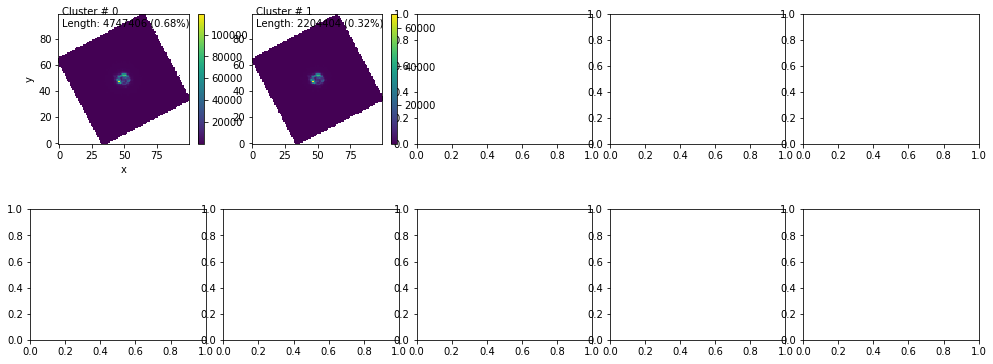

In [118]:
# Plot where the centers fall:
plt.clf()

plot_x = 'x'
plot_y = 'y'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

plot_from_df(data, 'Cas A', plot_x, plot_y)



'''
standardized_data_df = pd.DataFrame(standardized_data, columns=feature_list)

plot_from_df(standardized_data_df, 'Cas A', plot_x, plot_y)

for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



# Classify all of the points into their proper cluster:


data_np = np.array(data)
extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
      


cluster={}
cluster_e={}

fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):

    cluster[n]=[]
    
    for j in range(np.shape(standardized_data)[0]):
        if clusters[j]==n:
            cluster[n].append(data_np[j])
            #cluster_e[n].append(np.reshape(data_ml_rot_e[j,:],(resampling_shape,resampling_shape)))
            
    print('Cluster # ', n, ' length is ', len(cluster[n]), 
          ' fractional length is ', round(len(cluster[n])/np.shape(standardized_data)[0],2))
    nbins=100#int(len(x)/10)
    
    cluster_stack = np.vstack(cluster[n])
    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(len(cluster[n])/np.shape(standardized_data)[0],2))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis', origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


extent [[0.0, 1.0], [-0.9740518962075848, 1.0]]


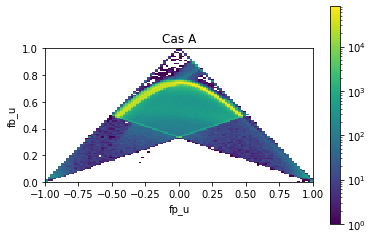

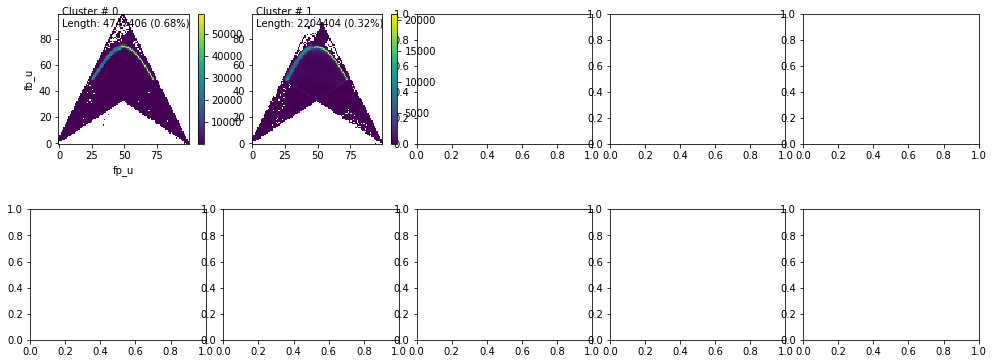

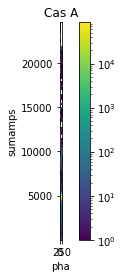

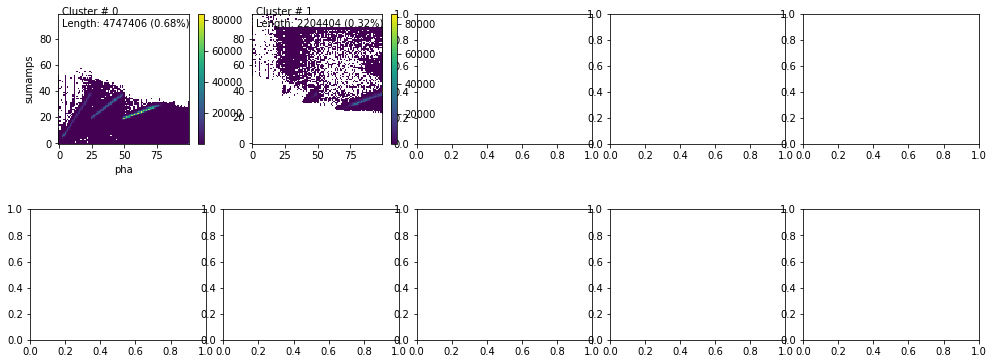

In [120]:
# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'fp_u'
plot_y = 'fb_u'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)


plot_from_df(data, 'Cas A', plot_x, plot_y)

'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()

'''


extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]
print('extent', extent)
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    cluster_stack = np.vstack(cluster[n])

    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(len(cluster[n])/np.shape(standardized_data)[0],2))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis', origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()


# Do the same thing with fp_u and fb_u
plt.clf()

plot_x = 'pha'
plot_y = 'sumamps'

index_x = all_feature_list.index(plot_x)
index_y = all_feature_list.index(plot_y)

plot_from_df(data, 'Cas A', plot_x, plot_y)
'''
for i in range(nclusters):
    plt.scatter(centers[i][index_x], centers[i][index_y])
plt.xlabel('normalized '+plot_x)
plt.ylabel('normalized '+plot_y)
plt.show()
'''



extent = [[np.min(data_np[:,index_y]), np.max(data_np[:,index_y])], [np.min(data_np[:,index_x]), np.max(data_np[:,index_x])]]

fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

#cluster_name=[]
for n in range(nclusters):
    
    cluster_stack = np.vstack(cluster[n])

    
    xs = cluster_stack[:,index_x]
    ys = cluster_stack[:,index_y]
    
    img_data, yedges, xedges = np.histogram2d(ys, xs, nbins, range=extent)
            #xedges[0], xedges[-1], yedges[0], yedges[-1]]

    #print('# Real events: ', len(input_data.loc[good_hyperbola]), '# All events: ',len(input_data))
    #print('# bg events: ', len(input_data)-len(input_data.loc[good_hyperbola]))
    #try:
    
    
    axs[n].annotate('Cluster # '+str(n)+'\nLength: '+str(len(cluster[n]))+' ('+str(round(len(cluster[n])/np.shape(standardized_data)[0],2))+'%)', 
                   xy = (0.03, 0.9), xycoords='axes fraction')
    
    im = axs[n].imshow(ma.masked_where(img_data==0, img_data),  
                    rasterized=True, cmap='viridis', origin='data')#, 
                  # norm=matplotlib.colors.LogNorm())#, extent=extent
    if n==0:
        axs[n].set_xlabel(plot_x)
        axs[n].set_ylabel(plot_y)

    plt.colorbar(im, ax = axs[n], fraction=0.046)

plt.show()
